# Explore LHC dataset

In [ ]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
from sklearn.manifold import TSNE

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.simulators.collider import WBFLoader


## Get data

In [2]:
n = 10000

In [3]:
sim = WBFLoader()
sim.latent_dim()

14

In [4]:
x, params = sim.load_dataset(train=True, dataset_dir="../data/samples/lhc", numpy=True, limit_samplesize=n)

10:16 experiments.simulators.collide INFO    Only using 10000 of 1000000 available samples


In [5]:
x_ = sim._preprocess(x, inverse=True)

In [ ]:
x_noise = np.random.normal(size=x.shape)

## Viz

In [19]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit(x)

x_tsne = tsne.transform(x)
noise_tsne = tsne.transform(x_noise)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 9.265s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.856963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.986755
[t-SNE] KL divergence after 1000 iterations: 2.191603


AttributeError: 'TSNE' object has no attribute 'transform'

In [ ]:
plt.figure(figsize=(8, 4))

ax = plt.subplot(1,2,1)
plt.scatter(
    x_tsne[:, 0],
    x_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C3"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

ax = plt.subplot(1,2,2)
plt.scatter(
    noise_tsne[:, 0],
    noise_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C0"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

plt.tight_layout()
plt.savefig("../figures/lhc_tsne.pdf")

## Determine weights for individual closure tests

In [20]:
random_closure_tests = np.mean(sim._closure_tests(x_noise), axis=1)
CLOSURE_TEST_WEIGHTS = 1. / random_closure_tests
print(", ".join([str(w) for w in CLOSURE_TEST_WEIGHTS]))

0.005733124397251814, 0.019373627498998545, 0.005601847357892751, 0.013246297554593486, 0.0051492718104518736, 0.005285928756022291, 0.5434573654744188, 0.5495540233428311, 0.548574528639762, 0.5499645858762766, 0.5443319900983565, 0.5477470269075005, 0.751120437331326, 0.6837450347638595, 0.479495732489328, 0.35411560084702814, 0.6944403914297372, 0.4581065620636643, 0.00338315127519218, 0.008990040230563823, 0.0029443731703010264, 0.0011509776322986742, 0.0027066953197164415, 0.0010181997312659812, 0.0037623941358973473, 0.003735274410662914, 0.0037745140586529515, 0.0037235471577507923, 0.0018995239678828314, 0.0007850227402417481, 1.1083823994444644, 0.6246407123110107, 0.47202092213106334, 0.5863775777004946


## Closure test vs noise

In [8]:
np.mean(sim.distance_from_manifold(x))

2.2684057161733498e-08

In [9]:
np.mean(sim.distance_from_manifold(x_noise))

1.0009224818481945

In [15]:
noises = np.geomspace(1.e-9, 1., 100)

closure = []

for noise in noises:
    closure.append(np.mean(sim.distance_from_manifold(x + noise * np.random.normal(size=x.shape))))

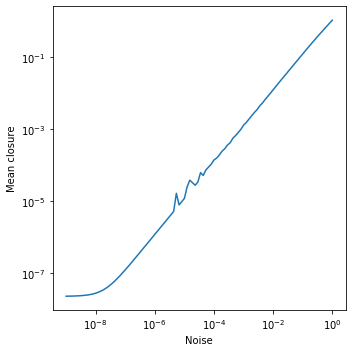

In [18]:
plt.figure(figsize=(5,5))

plt.plot(noises, closure)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Noise")
plt.ylabel("Mean closure")

plt.tight_layout()
plt.savefig("../figures/lhc_closure_vs_noise.pdf")
